In [1]:
import sys, os
import requests
import numpy as np
import pandas as pd
from dotenv import load_dotenv

In [2]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    
    mu = series.mean()
    sigma = series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold

In [3]:
data = pd.read_csv('C:/Users/Zhangchensi/bootcamp_Chensi_Zhang/project/data/processed/processed_data.csv')
data = data.iloc[:,1:]
data

open      high       low     close    volume  year
0     0.050354  0.046686  0.043518  0.045676  0.130251  2015
1     0.043057  0.040097  0.038797  0.038268  0.164745  2015
2     0.038937  0.037216  0.036898  0.038292  0.169450  2015
3     0.040491  0.039035  0.041924  0.041876  0.089477  2015
4     0.045269  0.048362  0.046804  0.051834  0.149426  2015
...        ...       ...       ...       ...       ...   ...
2668  0.332094  0.338466  0.343085  0.343933  0.182155  2025
2669  0.339121  0.338749  0.344107  0.342610  0.126241  2025
2670  0.338991  0.336765  0.340420  0.339747  0.139073  2025
2671  0.333577  0.334026  0.342306  0.338064  0.081290  2025
2672  0.332576  0.333436  0.340457  0.337270  0.087287  2025

[2673 rows x 6 columns]

In [4]:
target_col = 'y' if 'y' in data.columns else data.select_dtypes(include=['number']).columns[0]
data['outlier_iqr'] = detect_outliers_iqr(data[target_col])
data['outlier_z'] = detect_outliers_zscore(data[target_col], threshold=3.0)

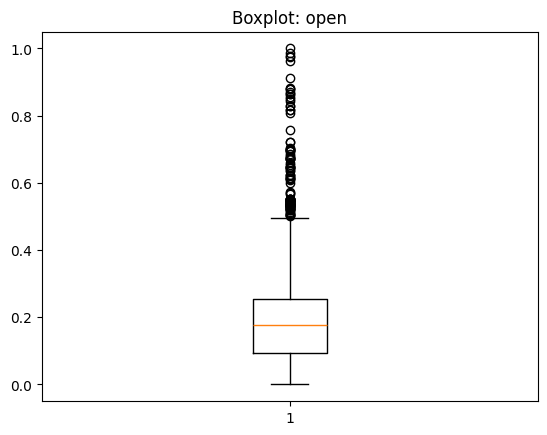

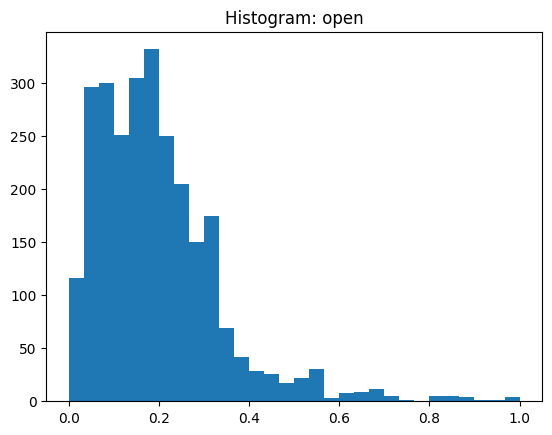

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.boxplot(data[target_col])
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(data[target_col], bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()

In [7]:
summ_all = data[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = data.loc[~data['outlier_iqr'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_w = None
if 'winsorize_series' in globals():
    w = winsorize_series(data[target_col])
    summ_w = w.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comp = pd.concat(
    {
        'all': summ_all,
        'filtered_iqr': summ_filtered,
        **({'winsorized': summ_w} if summ_w is not None else {})
    }, axis=1
)
comp

all  filtered_iqr
mean    0.196192      0.177126
median  0.177617      0.169119
std     0.138802      0.102459